In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [5]:
# load VAE model
config = process_config('NAB_config_scada1.json')#('NAB_config_centralized.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator

data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config, "Global")
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` me

Model loaded.


In [6]:
print(data.__dict__.keys())
for i in data.__dict__.keys():
    if (i not in ['config','train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']):
        print(i ,getattr(data,i))
for i in  ['train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']:
    print(i ,(getattr(data,i)['data']).shape)




dict_keys(['config', 'n_train_vae', 'n_val_vae', 'train_set_vae', 'val_set_vae', 'test_set_vae', 'n_train_lstm', 'n_val_lstm', 'train_set_lstm', 'val_set_lstm'])
n_train_vae 11312
n_val_vae 1257
n_train_lstm 11074
n_val_lstm 1231
train_set_vae (11312, 24, 1)
val_set_vae (1257, 24, 1)
test_set_vae (32, 24, 1)
train_set_lstm (11074, 12, 24, 1)
val_set_lstm (1231, 12, 24, 1)


In [7]:
config['dataset']

'nprs44'

In [6]:
# load LSTM model
lstm_model = lstmKerasModel("Global", config)
lstm_model.produce_embeddings(model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model()
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp_Global.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, checkpoint_path)

lstm input: (?, 11, 6)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Finish processing the embeddings of the entire dataset of Global.
lstm input: (?, 11, 6)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11, 6)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 11, 64)            18176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 11, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 11, 6)             1704      
Total params: 52,904
Trainable params: 52,904
Non-trainable params: 0
_________________________________________________________________
../experiments/local-results/SCADA1/scada1/batch-32/SCADA1-s

In [ ]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
# config['dataset'] = 'ecg_9'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]

# slice into rolling windows and rolling sequences
# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    time_seq = np.reshape(time_seq,(-1,config['n_channel']))
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win'], config['n_channel']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win'], config['n_channel']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.reshape(test_windows, (-1,config['l_win'],config['n_channel']))
test_seq = np.reshape(test_seq, (-1,config['l_seq'],config['l_win'],config['n_channel']))
print('test_windows ',test_windows.shape)
print('test_seq ',test_seq.shape)

The given sequence has 68658 samples


In [69]:
result


{'readings': array([[4.995, 4.34 ],
        [4.995, 4.34 ],
        [4.995, 4.34 ],
        ...,
        [4.985, 5.575],
        [4.995, 5.575],
        [5.015, 5.595]]),
 'idx_anomaly': array([4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031,
        4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042,
        4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053,
        4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064,
        4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075,
        4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086,
        4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097,
        4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108,
        4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119,
        4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130,
        4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141,


In [ ]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    # error_original = vae_embedding[1:] - lstm_embedding
    #print(error_original.shape)
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], config['n_channel'])),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    error_original = np.abs(recons_win_lstm - np.squeeze(test_seq[1:])).reshape((config['l_seq']-1,-1)) #them dong nay de tinh
    return lstm_recons_error, lstm_embedding_error, error_original
data.val_set_vae['data'] = np.asarray(data.val_set_vae['data'])
data.val_set_lstm['data'] = np.asarray(data.val_set_lstm['data'])
data.train_set_lstm['data'] = np.asarray(data.train_set_lstm['data'])
data.train_set_vae['data'] = np.asarray(data.train_set_vae['data'])
n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
val_lstm_error_original = np.zeros((n_val_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i], val_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])
    
n_train_lstm = data.train_set_lstm['data'].shape[0]
train_lstm_recons_error, train_lstm_embedding_error = np.zeros(n_train_lstm), np.zeros(n_train_lstm)
train_lstm_error_original = np.zeros((n_train_lstm,config['l_seq']-1,config['l_win']*config['n_channel'])) #them de tinh OCSVM
for i in range(n_train_lstm):
    train_lstm_recons_error[i], train_lstm_embedding_error[i], train_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.train_set_lstm['data'][i])

In [71]:
config['l_seq']

12

In [72]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

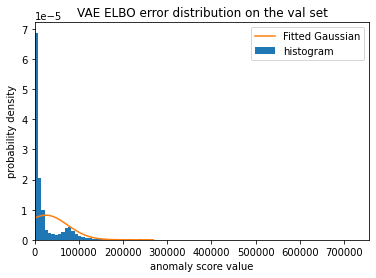

25% percentile: 1187.1899769376191
75% percentile: 22416.64882969156
These windows scored the top 1% of anomaly metric (214835.41358296157): 
[ 217  230  231  254  255  279  289  301  317  331  332  348  349  350
  370  397 1791 1808 1809 1810 1861 1862 1891 1892 1917 1918 1919 1934
 1935 1936 1991 1992 2020 2021 2022 2023 2024 2050 2051 2052 2053 2092
 2093 2117 2118 2140 2141 2167 2201 2202 2203 2234 2235 2236 5964 5965
 6211 6212 6213 6247 6248 6249 6250]


In [73]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

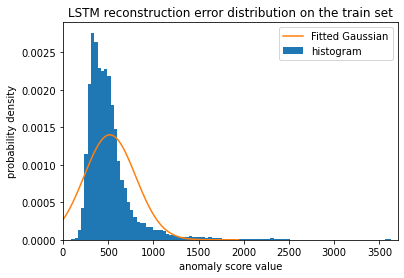

25% percentile: 350.6346030536119
75% percentile: 580.3493810809537
These windows scored the top 1% of anomaly metric (1681.6131269518273): 
[ 1430  1470  2282  2376  2486  2536  2627  2729  2738 16487 16494 16496
 16511 16541 16551 16554 16558 16562 16569 16579 16581 16582 16583 16593
 16600 16612 16621 16624 16690 16693 16694 16698 16709 16733 16770 16777
 16803 16807 16808 16819 16820 16826 16838 16847 16866 16876 16882 16909
 16911 16937 16949 16972 16986 17000 17010 17015 17021 17025 17031 17040
 17051 17080 17081 17097 17103 17116 17126 17184 17189 17196 17199 17210
 17221 17229 17243 17246 17259 17264 17312 17317 17326 17328 17343 17362
 17376 17378 17391 17399 17434 17435 17448 17471 17493 17504 17548 17558
 17561 17563 17577 17586 17590 17592 17603 17605 17615 17619 17620 17623
 17647 17683 17686 17706 17711 17721 17734 17737 17739 17742 17752 17769
 17781 17785 17795 17803 17823 17825 17832 17860 17865 17903 17915 17924
 17936 17938 17942 17943 17950 17960 18005 18014 18042 1

In [74]:
# Histogram of LSTM reconstruction error - train set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_train, lstm_recons_std_train = plot_histogram(train_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the train set', 
                                              mean=None, std=None, xlim=None)

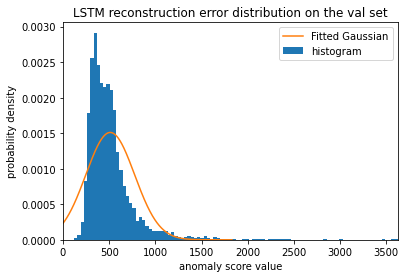

25% percentile: 350.11063926998133
75% percentile: 577.4669070999121
These windows scored the top 1% of anomaly metric (1558.5992555856108): 
[ 185  344  356 1835 1848 1849 1856 1857 1859 1873 1874 1887 1889 1903
 1917 1924 1946 1954 1961 1966 1975 1992 1993 2003 2012 2013 2014 2018
 2020 2033 2035 2055 2076 2090 2098 5761 5797 5798 5799 5808 5809 5810
 5820 5845 5847 5858 5860 5871 5872 5886 5898 5960 5961 5962 5973 5984
 6009 6018 6034 6036 6037]


In [75]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_val, lstm_recons_std_val = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [76]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
test_lstm_error_original = np.zeros((n_test_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i], test_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 1469


25% percentile: 433.7258671205575
75% percentile: 918.8542417263941
These windows scored the top 1% of anomaly metric (1197.5641999166373): 
[1223 1224 1225 1226 1227 1242 1243 1244 1245 1246 1247 1248 1249 1250
 1251]


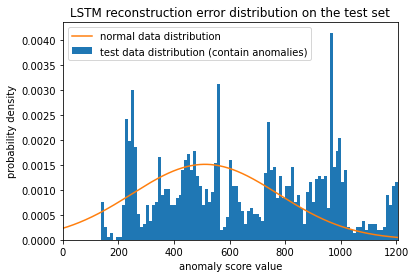

In [77]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m_val, std=lstm_recons_std_val, xlim=None, saveplot=True)

In [78]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(1469,)


In [79]:
print(result['idx_anomaly_test'])
print(list(anomaly_index_lstm))
print(test_labels_lstm)

[445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642
 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680 681 682 683 684 685 686 687 688 689 690 69

(767.9061083164128, 532.4569464087942, 661.1606067299771, 518.66916025671, 511.57378289113143)
(268.0100017529107, 243.4819151767316, 661.1606067299771, 285.1775134395463, 264.01956111334675)


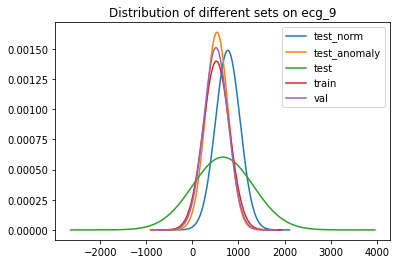

In [80]:
test_normal_idx = np.squeeze(np.argwhere(test_labels_lstm==0))
test_anomaly_idx = np.squeeze(np.argwhere(test_labels_lstm==1))
test_lstm_recons_error_normal = test_lstm_recons_error[test_normal_idx]
test_lstm_recons_error_anomaly = test_lstm_recons_error[test_anomaly_idx]
lstm_recons_m_test_normal = np.mean(test_lstm_recons_error_normal)
lstm_recons_std_test_normal = np.std(test_lstm_recons_error_normal)
lstm_recons_m_test_anomaly = np.mean(test_lstm_recons_error_anomaly)
lstm_recons_std_test_anomaly = np.std(test_lstm_recons_error_anomaly)
lstm_recons_m_test = np.mean(test_lstm_recons_error)
lstm_recons_std_test = np.mean(test_lstm_recons_error)

means = (lstm_recons_m_test_normal, lstm_recons_m_test_anomaly, lstm_recons_m_test, lstm_recons_m_train, lstm_recons_m_val)
stds = (lstm_recons_std_test_normal, lstm_recons_std_test_anomaly, lstm_recons_std_test, lstm_recons_std_train, lstm_recons_std_val)
for mean,std in zip(means,stds):
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    #x_axis = np.arange(-10000,10000)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
plt.legend(('test_norm', 'test_anomaly', 'test', 'train', 'val')) 
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of different sets on " + config['dataset'])
#print(lstm_recons_m_test,lstm_recons_std_test)
#print(lstm_recons_m_val,lstm_recons_std_val)
#print(lstm_recons_m_test_normal,lstm_recons_m_test_normal)
print(means)
print(stds)

In [81]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [82]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [83]:
def count_TP_TN_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_TN = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1 #both branch the same?

    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
        else:
            n_TN = n_TN + 1

    return n_TP, n_TN, n_FP, n_FN

In [84]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_TN, n_FP, n_FN = count_TP_TN_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)

    accuracy = (n_TP + n_TN) / (n_TP + n_TN + n_FP + n_FN)
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)

    return accuracy, precision, recall, F1, n_TP, n_TN, n_FP, n_FN

In [85]:
%time
n_threshold = 25
accuracy = np.zeros(n_threshold)
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
accuracy_aug = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    accuracy[i], precision[i], recall[i], F1[i], _, _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    accuracy_aug[i], precision_aug[i], recall_aug[i], F1_aug[i], _, _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.5 µs


In [86]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, accuracy is {}, precision is {}, recall is {}".format(accuracy[idx_best_threshold], precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
best_thres = np.min(threshold_list[idx_best_threshold])
print("At this threshold, accuracy is {}, precision is {}, recall is {}".format(accuracy_aug[idx_best_threshold], precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.6294896030245747
Best threshold is 183.256064999769
At this threshold, accuracy is 0.46630360789652825, precision is 0.4593103448275862, recall is 1.0
Average precision is 0.3387984300208174

Augmented detection:
Best F1 score is 0.7867690490253986
Best threshold is 850.2536643787892
At this threshold, accuracy is 0.7542545949625595, precision is 0.6484907497565725, recall is 1.0
Average precision is 0.5699207261586345


In [87]:
import math
from scipy.stats import norm

def KQp(data,q):
#UNTITLED3 Summary of this function goes here
#   Detailed explanation goes here
    data2 = np.sort(data) #sap xep tang dan
    n = np.shape(data2)[0] #kich thuoc
    p = 1-q #q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1));
    KQ=0;
    for i in range(1,n+1):
        a= ((i/n)-p)/h;
        b= (((i-1)/n)-p)/h;
        TP=(norm.cdf(a)-norm.cdf(b))*data2[i-1]; #normcdf thu trong matlab
        KQ=KQ+TP;    
    KQp = KQ;
    return KQp

for i in [0.05,0.025,0.01]:
    print("KQp is:", KQp(test_lstm_recons_error,i),"with q =",i)


KQp is: 1125.4321234005242 with q = 0.05
KQp is: 1181.2033962795992 with q = 0.025
KQp is: 1197.5365468793652 with q = 0.01


In [101]:
# Now select a threshold
threshold = best_thres
q_list = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.025]
temp = math.inf
q_best = 0
closest_thres = 0
for q in q_list:
    temp_thres = KQp(test_lstm_recons_error, q)
    #print(temp_thres,abs(temp_thres - threshold))
    if abs(temp_thres - threshold) < temp:
        temp = abs(temp_thres - threshold)
        q_best = q
        KQp_thres = temp_thres
    
print("Closest KQp threshold is {} at q = {}".format(KQp_thres,q_best))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, KQp_thres)
#print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
#print(anomaly_index_lstm)
#print(idx_detection_augmented)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using KQE:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

print("\nThreshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

KQp threshold is 862.7286701316083

PR evaluation using KQE:
Accuracy: 0.5534377127297482
Precision: 0.5068870523415978
Recall: 0.5525525525525525
F1: 0.5287356321839081
TP: 368
TN: 445
FP: 358
FN: 298

Threshold is 850.2536643787892

PR evaluation using augmented detection:
Accuracy: 0.7542545949625595
Precision: 0.6484907497565725
Recall: 1.0
F1: 0.7867690490253986
TP: 666
TN: 442
FP: 361
FN: 0


In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_labels_lstm,test_lstm_recons_error, pos_label = 1)
auc = metrics.auc(fpr,tpr)
print('AUC =', auc)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of ' + config['dataset'])
plt.legend(loc="lower right")
plt.show()

In [89]:
import numpy as np
for i in range(1,4):
    print(1/i)

1.0
0.5
0.3333333333333333


In [90]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [91]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    #t_test = result['t_test']
    test = result['test']
    t_test = np.array(range(result['test'].shape[0]))
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
#     axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        np.mean(result['train_m']), 
                                                                                        np.mean(result['train_std']),
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

In [92]:
# plot_detected_anomalies(idx_detection_augmented, 
#                         interval=config['l_win']*config['l_seq']/2, 
#                         dataset=dataset, 
#                         result=result, 
#                         detection_method='lstm reconstruction error',
#                         augmented_flag=1,
#                         y_scale=5,
#                         y_lim=5)

In [93]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#X_train =
#predicted_train =
#X_test = 
#predicted = 
y_test1 = np.where(test_labels_lstm==1,-1,1) #doi lai label

#OCSVM
#e=X_train - predicted_train
#e = val_lstm_error_original
e = train_lstm_error_original
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

nu = 0.5 #0.0055
gamma = 'auto' #1.5
from sklearn import svm
clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
clf.fit(d2_e)

#e_t=X_test - predicted
e_t = test_lstm_error_original
nsamples, nx, ny = e_t.shape

d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)

precision = precision_score(y_test1, y_scores, pos_label=-1)
recall    = recall_score(y_test1, y_scores, pos_label=-1)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, pos_label=-1)
print ('OSCVM recons abs: ')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)
print ('Accuracy : ', accuracy)


OSCVM recons abs: 
Precision :  0.32043530834340994
Recall:  0.3978978978978979
F1_score:  0.35498995311453446
Accuracy :  0.3444520081688223


In [94]:
result['test'].shape


(1756, 2)

In [95]:
a = [1, 1, -1, -1]
b = [1, -1, 1, 1]
precision = precision_score(a,b,pos_label=-1)
recall = recall_score(a,b,pos_label=-1)
print(precision)
print(recall)
f1 = f1_score(a, b, pos_label=-1)
print(f1)

0.0
0.0
0.0


In [96]:
[1,3,4] + [1,7,8]

[1, 3, 4, 1, 7, 8]

In [97]:
y_scores_idx_anomaly = np.squeeze(np.argwhere(y_scores==-1))
idx_augmented = augment_detected_idx(y_scores_idx_anomaly, anomaly_index_lstm)
y_scores[idx_augmented] = -1

precision = precision_score(y_test1, y_scores, pos_label=-1)
recall    = recall_score(y_test1, y_scores, pos_label=-1)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, pos_label=-1)
print ('\nOSCVM recons abs augmented: ')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)
print ('Accuracy : ', accuracy)


OSCVM recons abs augmented: 
Precision :  0.5423452768729642
Recall:  1.0
F1_score:  0.7032734952481521
Accuracy :  0.617426820966644
